# MC simulations using R feature selection 


In [1]:
import os
from sys import stdout

import time

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils
%matplotlib inline 
from math import sqrt
from scipy.signal import savgol_filter
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import scipy.io
from sklearn import model_selection
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.model_selection import learning_curve

from deap import base
from deap import creator
from deap import tools

from feature_selection import *
from utils import *


import warnings
warnings.filterwarnings('ignore')

# Data loading

In [2]:
#x_df = pd.read_csv('./slag_basic.csv', sep = ',')
#x_df = pd.read_csv('./slag_norm.csv', sep = ',')
#x_df = pd.read_csv('./slag_snv.csv', sep = ',')
#x_df = pd.read_csv('./slag_sum.csv', sep = ',')
#x_df = pd.read_csv('./slag_max.csv', sep = ',')
#x_df = pd.read_csv('./slag_ref-norm.csv', sep = ',')


#x_df = pd.read_csv('./slag2_basic.csv', sep = ',')
x_df = pd.read_csv('./slag2_snv.csv', sep = ',')
#x_df = pd.read_csv('./slag2_sum.csv', sep = ',')

values = x_df.values
#wl=x_df.columns.values
#print(wl.shape)

print(values.shape)
print(values[1].shape)
print(len(values))
x_df

(34, 3648)
(3648,)
34


,216.330000,216.370000,216.410000,216.450000,216.490000,216.520000,216.560000,216.600000,216.640000,216.680000,...,340.120000,340.150000,340.170000,340.200000,340.230000,340.260000,340.290000,340.320000,340.340000,340.370000
0,-34.051805,-52.797393,-53.416376,-50.619370,-46.209757,-48.165362,-43.447092,-42.931252,-25.927056,-13.107190,...,-103.066347,-27.629736,-23.198355,-9.552838,-19.357133,-49.271105,-57.096973,-42.160880,-19.763292,3.410259
1,-35.201055,-60.072356,-60.131801,-58.011798,-52.212617,-54.378624,-49.951903,-47.824779,-29.248469,-7.344227,...,-64.820653,24.694311,30.724761,52.985761,40.897109,-1.965884,-9.177440,12.457111,38.326027,68.500543
2,-61.725066,-83.949383,-82.440126,-80.868723,-73.935168,-76.909455,-69.878720,-64.227240,-43.100717,-21.326998,...,-92.475257,2.023462,0.789317,29.995880,11.053868,-22.786720,-25.143741,-3.095051,21.392923,46.330182
3,-48.572464,-79.293588,-82.789625,-76.847331,-63.186562,-69.113933,-67.715152,-62.796481,-29.173940,20.855619,...,-41.891570,92.651836,117.342210,175.045072,159.748589,81.375420,55.515121,95.928675,150.131072,219.660992
4,-35.451084,-58.618905,-60.676861,-56.766651,-51.687895,-52.423113,-50.307504,-46.783010,-24.661733,3.294162,...,-72.384351,24.596668,30.479041,61.472509,45.679448,-2.723485,-19.447900,6.068628,38.178162,84.967469
5,-36.318534,-59.268844,-59.596290,-54.995849,-49.873501,-51.412468,-51.321612,-46.330628,-26.673483,-1.781259,...,-85.220802,9.748134,12.990046,40.482499,23.649100,-20.107374,-35.236177,-11.397567,20.329398,58.950593
6,-37.040546,-62.185171,-62.135035,-58.396400,-52.323476,-54.757376,-52.409939,-48.609747,-25.429684,4.852922,...,-76.681036,30.610929,34.763918,73.193085,54.302760,1.233609,-14.648764,12.446077,50.342167,101.717754
7,-36.492235,-60.345347,-61.370589,-60.676859,-51.827385,-56.440431,-52.455686,-49.064011,-25.711533,0.303746,...,-81.572597,26.606029,25.222579,59.500709,39.703889,-10.054296,-25.747500,-0.519163,34.680482,80.295231
8,-35.924201,-65.734934,-69.514183,-66.303034,-55.901911,-60.105900,-56.578816,-54.499947,-28.925850,-1.506994,...,-78.649119,33.149389,48.557781,92.230816,82.794434,23.648323,6.844246,33.833117,75.478331,124.108603
9,-31.648282,-51.030200,-52.764198,-47.671985,-44.046021,-44.871680,-43.075841,-39.489770,-21.918860,0.337684,...,-77.840058,6.571978,4.564996,31.914588,18.865411,-18.088156,-29.448928,-6.083044,18.658541,53.447369


[[216.33 216.37 216.41 ... 340.32 340.34 340.37]]
wl shape:  (3648, 1)


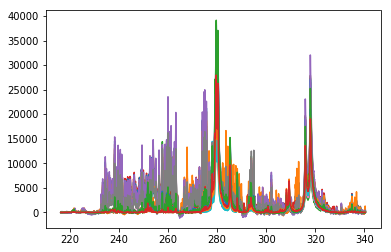

In [3]:
#This is just for visualizing the various plots of the samples
mat = scipy.io.loadmat("./data/H01.mat")
wl= mat["wl"]
print(wl.T)
print("wl shape: ", wl.shape)

for i in range(len(values)):
    plt.plot(wl, values[i])
    #plt.show()

In [4]:
print(wl[0])
print(wl[-1])

[216.33]
[340.37]


In [5]:
df_y = pd.read_csv('./slag_concentration.csv')
print(type(df_y))
concentration=df_y.values
print(concentration.shape)
#print(concentration)

y_values=df_y.values
y_all=pd.DataFrame(y_values[:,2:10])
#print(y_all)
df_y

<class 'pandas.core.frame.DataFrame'>
(34, 11)


,Sample,MgO,Al2O3,SiO2,FeO,MnO,Cr2O3,P2O5,V2O5,TiO2,Ca tot
0,H01,25.00,9.61,13.20,18.30,1.99,0.20,0.23,0.18,1.03,37.98
1,H02,18.00,5.04,14.20,18.90,2.10,0.28,0.26,0.06,1.07,44.72
2,H03,21.10,6.14,10.60,20.20,5.82,0.61,0.40,0.14,0.86,38.72
3,H04,15.50,4.07,12.80,26.70,3.35,0.52,0.31,0.08,1.07,38.44
4,H05,17.10,4.14,14.80,21.70,1.72,0.20,0.29,0.18,1.07,43.38
5,H06,15.90,4.34,16.50,18.90,1.29,0.10,0.30,0.11,1.10,45.53
6,H07,14.30,4.12,16.20,19.00,1.21,0.09,0.27,0.06,1.08,46.35
7,H08,13.00,4.05,16.10,21.00,1.26,0.10,0.28,0.06,1.09,45.29
8,H09,10.60,7.30,14.30,33.20,2.75,0.42,0.32,0.09,1.12,32.81
9,H10,19.30,6.50,14.70,17.40,2.72,0.31,0.28,0.09,1.06,42.64


In [6]:
y_val = concentration[:,10] # 1-Mg, 2-Al, 3-Si, 4-Fe, 5-Mn, 6-Cr, 10-Ca
#print(y_val)
print(y_val.shape)
y_df= pd.DataFrame(y_val)
y_df.T

(34,)


,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,37.98,44.72,38.72,38.44,43.38,45.53,46.35,45.29,32.81,42.64,...,35.12,43.81,35.25,35.39,51.4,53,42.55,50.1,42.53,44.5


### wavelenght selection import

In [20]:
sel= pd.read_csv('./selected_wavelengths/selecta_noBaseline_Fe_ipw-f_snv.txt', sep= ' |,|\n', header = None)
#sel= sel.dropna()
#print(sel, "\n")
sel= sel.values.flatten()
sel= sel[~np.isnan(sel)]
sel = [int(i)-1 for i in sel]
print("number of selected wavelengths: ", len(sel))
#print(sel)

number of selected wavelengths:  14


In [8]:
sel=sel[:-1]
#print(wl.shape)
wl_sel= wl[sel]
print(wl_sel.shape)
wl_sel.T

(13, 1)


array([[222.59, 222.63, 222.67, 222.71, 222.75, 222.78, 222.82, 321.17,
        321.2 , 321.23, 321.26, 321.29, 321.32]])

In [9]:
#target = [251.59, 288.12, 390.60] #peaks for Si
#target = [277.91, 279.59, 280.23, 281.78, 285.27, 383.74] #peaks for Mg
#target = [292.83, 293.61, 294.91, 403.25, 404.63, 404.56] #peaks for Mn
#target= [296.06,324.73, 327.37] #peaks for Cu
#target= [202.60, 206.20, 213.90, 330.14, 334.41] #peaks for Zn
#target = [267.695, 284.304, 311.84, 311.967, 312.5, 313.146, 357.792, 359.273, 360.439, 425.39, 429.16] #Cr
#target = [308.16, 309.30, 394.63, 396.16]
target= [310.03, 312.69, 404.63, 426.17, 373.69, 372.03, 373.43, 257.67, 259.36, 259.90, 274.89, 356.94, 363.04] #Fe#
#target = [251.59, 288.12, 390.60, 277.91, 279.59, 280.23, 281.78, 383.74, 285.27, 292.83, 293.61, 294.91, 403.25, 404.63, 404.56, 296.06,324.73, 327.37, 330.14, 334.41, 310.03, 312.69, 404.63, 426.17, 373.69, 372.03, 373.43, 257.67, 259.36, 259.90, 274.89, 356.94, 363.04]
#len(target)

In [10]:
a = []
b = []
for t in target:
    for i in range(len(wl_sel)):
        if abs(wl_sel[i][0]-t) <= 0.2:
            a.append(wl_sel[i][0])
            b.append(i)
            
print("number of selected peaks: ",len(a), "\n")
print(a, "\n")
#print(b)

number of selected peaks:  0 

[] 



For Silicon (Si) the peaks are at **251.59, 288.12, 390.60**

For Magnesium (Mg) the peaks are at **277.91, 279.59, 280.23, 281.78, 383.74, 285.27**

For Manganese (Mn) the peaks are at **292.83, 293.61, 294.91, 403.25, 404.63, 404.56**

For Copper (Cu) the peaks are at **296.06,324.73, 327.37**

For Zinc (Zn) the peaks are at **202.55, 206.20, 213.90, 330.14, 334.41**

In [11]:
x_selecta = pd.DataFrame(x_df.values[:,sel])
#x_selecta = pd.DataFrame(x_df.values[:,b])
x_selecta

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-29.569016,-39.086462,-28.092207,-12.267150,5.036278,12.410807,12.726294,2215.350621,2238.396410,2311.594749,2220.785176,2247.576190,2306.500441
1,-27.442107,-38.347832,-27.840647,-6.956473,15.010481,28.005809,28.079506,2855.552470,2881.434897,2954.786191,2850.689535,2885.123705,2965.408426
2,-9.676802,-16.199717,-1.627824,20.545973,41.638057,50.842667,52.511897,3230.042765,3286.884310,3414.592550,3360.037464,3392.789744,3401.641513
3,-48.447868,-61.815109,-46.248409,-8.879511,34.645554,64.641733,57.508988,3813.833979,3875.030997,3953.845356,3851.565539,3957.898153,4124.489173
4,-40.938835,-53.057425,-43.662358,-21.440929,4.310326,19.485887,17.025799,2966.094556,2997.059397,3062.262247,2942.259894,2981.622857,3098.967224
5,-43.636304,-52.164247,-48.349971,-23.818507,-1.749375,9.395856,8.721854,3335.052835,3354.787416,3408.459099,3282.378766,3315.400033,3429.351946
6,-48.189149,-61.995078,-52.965758,-28.340403,-2.746037,11.062754,10.982864,3339.316426,3358.554459,3421.108104,3291.837820,3335.669558,3470.343049
7,-46.910355,-58.521162,-47.364740,-25.041237,-1.781365,12.088732,9.706026,3392.224616,3412.020263,3471.155510,3334.463477,3370.069440,3495.846333
8,-34.621778,-44.510586,-30.713836,0.037391,35.421835,57.462952,53.791455,2917.168607,2950.978852,3032.997665,2939.025455,3009.338617,3145.692738
9,-30.543638,-39.036880,-30.900625,-12.040981,7.422787,13.963650,15.785177,2730.775457,2772.461932,2843.333132,2756.452591,2802.008137,2876.891200


## Partial Least Squares

In [19]:
R2_predictions = []
rmse_predictions = []
#R2_cross_val = []
#rmse_cross_val = []

for i in range(1,16):
#for i in range(100,116):
    seed = i
    print ("seed: ", seed)
    
    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)
    
    #cross validation to find optimal number of components
    plscomp = optimise_pls_cv(X_train, y_train, min(30, X_train.shape[1]), plot_components=False) 

    #PLS model
    #pls =  PLSRegression(n_components=max(6,plscomp), scale=True)
    #pls =  PLSRegression(n_components=max(6, plscomp), scale=False)
    
    pls =  PLSRegression(n_components=plscomp, scale=True)
    #pls =  PLSRegression(n_components=plscomp, scale=False)

    # Fit
    pls.fit(X_train, y_train)

    y_cv = cross_val_predict(pls, X_train, y_train, cv=10)
    y_pred = pls.predict(X_test)


    # Calculate score and error
    r2_cv = r2_score(y_train, y_cv)
    r2_p = r2_score(y_test, y_pred)

    rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
    rmse = sqrt(mean_squared_error(y_test, y_pred))

    #print("R2_pred: ", r2_p)
    #print("RMSE_pred: ", rmse, "\n")
    
    R2_predictions.append(r2_p)
    rmse_predictions.append(rmse)
    
print("FINAL ESTIMATIONS:")   
print("R^2:")
#print(R2_predictions)
print("mean: ",np.mean(R2_predictions))
print("std dev: ",np.std(R2_predictions, ddof=1))
print("")
print("rmse:")
#print(rmse_predictions)
print("mean: ",np.mean(rmse_predictions))
print("std dev: ",np.std(rmse_predictions, ddof=1))


print("")
print(np.mean(R2_predictions))
print(np.std(R2_predictions, ddof=1))
print("")
#print(rmse_predictions)
print(np.mean(rmse_predictions))
print(np.std(rmse_predictions, ddof=1))

seed:  1
100% completed
Suggested number of components:  7

seed:  2
100% completed
Suggested number of components:  6

seed:  3
100% completed
Suggested number of components:  3

seed:  4
100% completed
Suggested number of components:  3

seed:  5
100% completed
Suggested number of components:  6

seed:  6
100% completed
Suggested number of components:  4

seed:  7
100% completed
Suggested number of components:  5

seed:  8
100% completed
Suggested number of components:  3

seed:  9
100% completed
Suggested number of components:  3

seed:  10
100% completed
Suggested number of components:  5

seed:  11
100% completed
Suggested number of components:  3

seed:  12
100% completed
Suggested number of components:  5

seed:  13
100% completed
Suggested number of components:  3

seed:  14
100% completed
Suggested number of components:  3

seed:  15
100% completed
Suggested number of components:  6

FINAL ESTIMATIONS:
R^2:
mean:  -0.34710127737407015
std dev:  0.9387385051376091

rmse:
mean: 

## Simple Linear Model

In [13]:
R2_predictions = []
rmse_predictions = []
#R2_cross_val = []
#rmse_cross_val = []

for i in range(1,16):
    seed = i
    print ("seed: ", seed)
    
    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)
    
    
    lm = linear_model.LinearRegression()

    model = lm.fit(X_train, y_train)

    predictions = lm.predict(X_test)
    y_cv = cross_val_predict(lm, X_train, y_train, cv=10)

    r2_cv = r2_score(y_train, y_cv)
    r2_p = r2_score(y_test, predictions)

    rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
    rmse = sqrt(mean_squared_error(y_test, predictions))

    #print("R2_pred: ", r2_p)
    #print("RMSE_pred: ", rmse, "\n")
    
    R2_predictions.append(r2_p)
    rmse_predictions.append(rmse)

print("")    
print("FINAL ESTIMATIONS:") 
print("R^2:")
#print(R2_predictions)
print("mean: ",np.mean(R2_predictions))
print("std dev: ",np.std(R2_predictions, ddof=1))
print("")
print("rmse:")
#print(rmse_predictions)
print("mean: ",np.mean(rmse_predictions))
print("std dev: ",np.std(rmse_predictions, ddof=1))

print("")
print(np.mean(R2_predictions))
print(np.std(R2_predictions, ddof=1))
print("")
#print(rmse_predictions)
print(np.mean(rmse_predictions))
print(np.std(rmse_predictions, ddof=1))

seed:  1
seed:  2
seed:  3
seed:  4
seed:  5
seed:  6
seed:  7
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  13
seed:  14
seed:  15

FINAL ESTIMATIONS:
R^2:
mean:  -1.5158025623507574
std dev:  2.2349529022830104

rmse:
mean:  5.589594711760335
std dev:  2.1249476711793878

-1.5158025623507574
2.2349529022830104

5.589594711760335
2.1249476711793878


## Elastic Net

In [14]:
R2_predictions = []
rmse_predictions = []
#R2_cross_val = []
#rmse_cross_val = []

for i in range(1,16):
    seed = i
    print ("seed: ", seed)
    
    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)
    
    alphas = [0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]

    mses = []

    for a in alphas:
        model = ElasticNet(alpha=a).fit(X_train,y_train)   

        y_cv = cross_val_predict(model, X_train, y_train, cv=10)
        mse = mean_squared_error(y_train, y_cv)
        score = model.score(X_train, y_train)
        #pred_y = model.predict(X_test)
        #mse = mean_squared_error(y_test, pred_y)
        mses.append(mse)
        #print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))
        
    best_index =np.argmin(mses)
    print("best alpha: ", alphas[best_index], "\n")
    
    model = ElasticNet(alpha=alphas[best_index]).fit(X_train,y_train)   

    y_cv = cross_val_predict(model, X_train, y_train, cv=10)
    y_pred = model.predict(X_test)


    # Calculate score and error
    r2_cv = r2_score(y_train, y_cv)
    r2_p = r2_score(y_test, y_pred)

    rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    #print("R2_pred: ", r2_p)
    #print("RMSE_pred: ", rmse, "\n")
    
    R2_predictions.append(r2_p)
    rmse_predictions.append(rmse)

    
print("FINAL ESTIMATIONS:") 
print("R^2:")
#print(R2_predictions)
print("mean: ",np.mean(R2_predictions))
print("std dev: ",np.std(R2_predictions, ddof=1))
print("")
print("rmse:")
#print(rmse_predictions)
print("mean: ",np.mean(rmse_predictions))
print("std dev: ",np.std(rmse_predictions, ddof=1))

print("")
print(np.mean(R2_predictions))
print(np.std(R2_predictions, ddof=1))
print("")
#print(rmse_predictions)
print(np.mean(rmse_predictions))
print(np.std(rmse_predictions, ddof=1))

seed:  1
best alpha:  0.7 

seed:  2
best alpha:  1 

seed:  3
best alpha:  1 

seed:  4
best alpha:  0.3 

seed:  5
best alpha:  0.7 

seed:  6
best alpha:  1 

seed:  7
best alpha:  0 

seed:  8
best alpha:  1 

seed:  9
best alpha:  1 

seed:  10
best alpha:  0 

seed:  11
best alpha:  1 

seed:  12
best alpha:  1 

seed:  13
best alpha:  1 

seed:  14
best alpha:  1 

seed:  15
best alpha:  1 

FINAL ESTIMATIONS:
R^2:
mean:  -0.1342999866314936
std dev:  0.8698290612211121

rmse:
mean:  3.91084746309986
std dev:  1.1903854520237047

-0.1342999866314936
0.8698290612211121

3.91084746309986
1.1903854520237047


## Random Forest

In [15]:
y_test=np.ravel(y_test)
print(y_test.shape)
y_train=np.ravel(y_train)
print(y_train.shape)

(7,)
(27,)


In [16]:
## R2_predictions = []
rmse_predictions = []
#R2_cross_val = []
#rmse_cross_val = []

for i in range(1,16):
    seed = i
    print ("seed: ", seed)
    
    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)
    
    
    rf = RandomForestRegressor(n_estimators = 1000, max_depth=30, random_state = seed)
    # Train the model on training data

    rf.fit(X_train, y_train);

    # Use the forest's predict method on the test data
    #y_cv = cross_val_predict(rf, X_train, y_train, cv=10)
    predictions = rf.predict(X_test)


    # Calculate score and error
    r2_cv = r2_score(y_train, y_cv)
    r2_p = r2_score(y_test, predictions)

    rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
    rmse = sqrt(mean_squared_error(y_test, predictions))

    #print("R2_pred: ", r2_p)
    #print("RMSE_pred: ", rmse, "\n")
    
    R2_predictions.append(r2_p)
    rmse_predictions.append(rmse)

print("")    
print("FINAL ESTIMATIONS:") 
print("R^2:")
#print(R2_predictions)
print("mean: ",np.mean(R2_predictions))
print("std dev: ",np.std(R2_predictions, ddof=1))
print("")
print("rmse:")
#print(rmse_predictions)
print("mean: ",np.mean(rmse_predictions))
print("std dev: ",np.std(rmse_predictions, ddof=1))


print("")
print(np.mean(R2_predictions))
print(np.std(R2_predictions, ddof=1))
print("")
#print(rmse_predictions)
print(np.mean(rmse_predictions))
print(np.std(rmse_predictions, ddof=1))

seed:  1
seed:  2
seed:  3
seed:  4
seed:  5
seed:  6
seed:  7
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  13
seed:  14
seed:  15

FINAL ESTIMATIONS:
R^2:
mean:  -0.08278119833359444
std dev:  0.67554608953171

rmse:
mean:  4.012540248756896
std dev:  1.4076694786009611

-0.08278119833359444
0.67554608953171

4.012540248756896
1.4076694786009611


## SVM

In [17]:
"""R2_predictions = []
rmse_predictions = []
#R2_cross_val = []
#rmse_cross_val = []

for i in range(1,16):
    seed = i
    print ("seed: ", seed)
    
    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)
    
    X_train = StandardScaler().fit_transform(X_train.values)
    X_test = StandardScaler().fit_transform(X_test.values)
    
    #KFold cross validator
    kf = KFold(n_splits=5, shuffle=True, random_state=seed) 

    gamma_values = [1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.001, 0.0001,2,5,10,20]
    accuracy_scores=[]

    # Do model selection over all the possible values of gamma
    for gamma in gamma_values:
        # Train a classifier with current gamma
        svr = SVR(kernel='linear', C=gamma)

        # Compute cross-validated accuracy scores
        scores = cross_val_score(svr, X_train, y_train, cv=kf.split(X_train), scoring = 'r2' )


        accuracy_score = scores.mean()
        accuracy_scores.append(accuracy_score)

    # Get the gamma with highest mean accuracy
    best_index = np.array(accuracy_scores).argmax()
    best_gamma = gamma_values[best_index]
    #print("best index: ",best_index)
    #print("best gamma: ", best_gamma)

    # Train over the full training set with the best gamma
    svr = SVR( kernel='linear', C=best_gamma)
    svr.fit(X_train, y_train)

    # Evaluate on the test set 
    y_pred = svr.predict(X_test)
    #cross-val results
    y_cv = cross_val_predict(svr, X_train, y_train, cv=10)

    # Calculate score and error
    r2_cv = r2_score(y_train, y_cv)
    r2_p = r2_score(y_test, y_pred)

    rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    #print("R2_pred: ", r2_p)
    #print("RMSE_pred: ", rmse, "\n")
    
    R2_predictions.append(r2_p)
    rmse_predictions.append(rmse)

print("")    
print("FINAL ESTIMATIONS:") 
print("R^2:")
#print(R2_predictions)
print("mean: ",np.mean(R2_predictions))
print("std dev: ",np.std(R2_predictions, ddof=1))
print("")
print("rmse:")
#print(rmse_predictions)
print("mean: ",np.mean(rmse_predictions))
print("std dev: ",np.std(rmse_predictions, ddof=1))


print("")
print(np.mean(R2_predictions))
print(np.std(R2_predictions, ddof=1))
print("")
#print(rmse_predictions)
print(np.mean(rmse_predictions))
print(np.std(rmse_predictions, ddof=1))

"""

'R2_predictions = []\nrmse_predictions = []\n#R2_cross_val = []\n#rmse_cross_val = []\n\nfor i in range(1,16):\n    seed = i\n    print ("seed: ", seed)\n    \n    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)\n    \n    X_train = StandardScaler().fit_transform(X_train.values)\n    X_test = StandardScaler().fit_transform(X_test.values)\n    \n    #KFold cross validator\n    kf = KFold(n_splits=5, shuffle=True, random_state=seed) \n\n    gamma_values = [1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.001, 0.0001,2,5,10,20]\n    accuracy_scores=[]\n\n    # Do model selection over all the possible values of gamma\n    for gamma in gamma_values:\n        # Train a classifier with current gamma\n        svr = SVR(kernel=\'linear\', C=gamma)\n\n        # Compute cross-validated accuracy scores\n        scores = cross_val_score(svr, X_train, y_train, cv=kf.split(X_train), scoring = \'r2\' )\n\n\n        accuracy_score = scores.mean()\n  

## PCR

In [18]:
"""R2_predictions = []
rmse_predictions = []
#R2_cross_val = []
#rmse_cross_val = []

for i in range(1,16):
    seed = i
    print ("seed: ", seed)
    
    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)
    
    #cross validation to find optimal number of components
    pca_comp = optimise_pca_cv(X_train, y_train, 40, plot_components=False) 

    # PCA
    X_std = StandardScaler().fit_transform(X_train)
    X_std_test = StandardScaler().fit_transform(X_test)

    pca = PCA(n_components= min(X_train.shape[0], pca_comp))
    PC=pca.fit(X_std)

    x_pc = pca.fit_transform(X_std)
    x_test_pc = pca.transform(X_std_test)
    #print(x_pc.shape)
    #print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
    
    regr = linear_model.LinearRegression()
    # Fit
    regr.fit(x_pc, y_train)

    # Cross-validation and prediction
    y_cv = cross_val_predict(regr , x_pc, y_train, cv=10)
    y_pred = regr.predict(x_test_pc)

    # Calculate score and error
    r2_cv = r2_score(y_train, y_cv)
    r2_p = r2_score(y_test, y_pred)

    rmse_cv = sqrt(mean_squared_error(y_train, y_cv))
    rmse_p = sqrt(mean_squared_error(y_test, y_pred))

    #print("R2_pred: ", r2_p)
    #print("RMSE_pred: ", rmse, "\n")
    
    R2_predictions.append(r2_p)
    rmse_predictions.append(rmse_p)
    
print("FINAL ESTIMATIONS:")   
print("R^2:")
#print(R2_predictions)
print("mean: ",np.mean(R2_predictions))
print("std dev: ",np.std(R2_predictions, ddof=1))
print("")
print("rmse:")
#print(rmse_predictions)
print("mean: ",np.mean(rmse_predictions))
print("std dev: ",np.std(rmse_predictions, ddof=1))


print("")
print(np.mean(R2_predictions))
print(np.std(R2_predictions, ddof=1))
print("")
#print(rmse_predictions)
print(np.mean(rmse_predictions))
print(np.std(rmse_predictions, ddof=1))

"""

'R2_predictions = []\nrmse_predictions = []\n#R2_cross_val = []\n#rmse_cross_val = []\n\nfor i in range(1,16):\n    seed = i\n    print ("seed: ", seed)\n    \n    X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = seed)\n    \n    #cross validation to find optimal number of components\n    pca_comp = optimise_pca_cv(X_train, y_train, 40, plot_components=False) \n\n    # PCA\n    X_std = StandardScaler().fit_transform(X_train)\n    X_std_test = StandardScaler().fit_transform(X_test)\n\n    pca = PCA(n_components= min(X_train.shape[0], pca_comp))\n    PC=pca.fit(X_std)\n\n    x_pc = pca.fit_transform(X_std)\n    x_test_pc = pca.transform(X_std_test)\n    #print(x_pc.shape)\n    #print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))\n    \n    regr = linear_model.LinearRegression()\n    # Fit\n    regr.fit(x_pc, y_train)\n\n    # Cross-validation and prediction\n    y_cv = cross_val_predict(regr , x_pc, y_train, cv=10)\n